In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
class TicTacToeSmall():
    
    def __init__(self):
        self.board = np.zeros((3, 3))
        self.side = None
        self.progress = None
        self.done = None
        
    def reset(self):
        self.__init__()

    @property
    def hash_board(self):
        return hash(self.board.data.tobytes())
        
    def _check_align(self, array):
        return 0 not in array and np.unique(array).size == 1
        
    def _eval_board(self):
        
        # 3 circles / crosses align in row
        for row in self.board: 
            if self._check_align(row): return 'win'
        
        # 3 circles / crosses align in col
        for col in self.board.T: 
            if self._check_align(col): return 'win'
        
        # 3 circles / crosses align in diagonal
        diag = np.diagonal(self.board)
        if self._check_align(diag): return 'win'
        
        # 3 circles / crosses align in opposite diagonal
        oppo_diag = np.diagonal(np.fliplr(self.board))
        if self._check_align(oppo_diag): return 'win'
        
        # game board filled
        if 0 not in np.unique(self.board): return 'draw'
        
        return 'continue'
    
    def step(self, action, side):
        
        assert self.board[action] == 0, 'the position is filled'
        
        self.side = side
        
        if side == 'circle':
            self.board[action] = -1
        elif side == 'cross' :
            self.board[action] = 1
        
        self.progress = self._eval_board()
        if self.progress == 'continue':
            reward = 0
            done = False
        elif self.progress == 'win':
            reward = 1
            done = True
        elif self.progress == 'draw':
            reward = 0
            done = True
        
        return self.board, reward, done
    
    @property
    def action_space(self):
        advanced_indices = np.where(self.board == 0)
        actions = []
        for x, y in zip(advanced_indices[0], advanced_indices[1]):
            actions.append((x, y))
        return actions
    
    def sample_action_space(self):
        index = np.random.randint(len(self.action_space))
        return self.action_space[index]

In [4]:
def switch_player(player):
    if player == 'circle': return 'cross'
    elif player == 'cross': return 'circle'

In [5]:
def board_to_str(board):
        board_str = ''
        for i, row in enumerate(board):
            for item in row:
                if item == 0:
                    board_str += ' '
                elif item == -1:
                    board_str += 'o'
                elif item == 1:
                    board_str += 'x'
            if i < 2:
                board_str += '\n'
        return board_str

## Random round

In [6]:
for i in range(500):
    
    game = TicTacToeSmall()
    done = False
    player = np.random.choice(['circle', 'cross'])

    while done != True:
        action = game.sample_action_space()
        board, reward, done = game.step(action, player)
        player = switch_player(player)
        
print(board_to_str(game.board))
print(f'Last player: {game.side}')
if game.progress == 'draw':
    print(f'Game progress: {game.progress}')
elif game.progress == 'win':
    print(f'Game progress: {game.side} {game.progress}s')

xxo
oxx
ooo
Last player: circle
Game progress: circle wins


In [7]:
# for i in range(num_iters):
    # initialize S
    # done = False
    # while not done: (traversal loop, same for tabular and approx method)
        # pick an action according to qsa
        # episode_sa.append(s, a)
        # s, r, done = step(s, a); episode_r.append(r)
    # cumulative_reward = 0
    # for t in reversed(range(len(episode_r))):
        # cumulative_reward = cumulative_reward + episode_r[t]
        # if if episode_sa[t] not in episode_sa[:t]:
        #    update_total_returns
        #    update_total_occurrence
        #    update_mc_estimate at specific qsa spot
        #    act greedily wrt qsa

In [8]:
a = {1:2, 2:3}
for i, (j, k) in enumerate(a.items()):
    print(i, j, k)

0 1 2
1 2 3


In [160]:
class Callback():
    
    def on_train_begin(self, logs={}, plot=False):
        self.i = 0
        self.x = []
        self.p1_wins = 0
        self.p2_wins = 0
        self.wins_ratios = []
        self.lower_baselines = np.ones((30, ))
        self.upper_baselines = np.ones((30, )) * 1.2
        if plot:
            self.fig = plt.figure()

    def on_iter_end(self, logs={}, plot=False):
        
        self.x.append(self.i)
        self.i += 1
        
        if logs.get('p1_reward') == 1: self.p1_wins += 1
        elif logs.get('p2_reward') == 1: self.p2_wins += 1
        
        self.wins_ratios.append(self.p1_wins / (self.p2_wins + 0.00001))
        
        if plot:
            clear_output(wait=True)

            plt.plot(self.x, self.wins_ratios, label="p1_wins/p2_wins")
            plt.plot(self.x, self.lower_baselines[:len(self.x)], label="lower baseline")
            plt.plot(self.x, self.upper_baselines[:len(self.x)], label="upper baseline")
            plt.legend(loc='lower right')
            plt.show()

In [404]:
class Learner(Callback):

    def __init__(self, game, num_iters, epsilon, opponent='random', method='tabular'):
        self.game = game
        self.epsilon = epsilon
        self.num_iters = num_iters
        self.total_returns = {}
        self.total_occurrences = {}
        self.method = method
        self.opponent = opponent
        if self.method == 'tabular': self.qsa_table = {}
        elif self.method == 'nn': self.nn = None
        
    def reset(self):
        self.__init__()
        
    def _switch_player(self, player):
        if player == 'circle': return 'cross'
        elif player == 'cross': return 'circle'
    
    def _update_total_returns(self, sa_pair, cumulative_rewards):
        if sa_pair in self.total_returns.keys(): self.total_returns[sa_pair] += cumulative_rewards
        else: self.total_returns[sa_pair] = cumulative_rewards
        
    def _update_total_occurrences(self, sa_pair):
        if sa_pair in self.total_occurrences.keys(): self.total_occurrences[sa_pair] += 1
        else: self.total_occurrences[sa_pair] = 1
    
    def _update_qsa_table(self, sa_pair, cumulative_reward):
        self._update_total_returns(sa_pair, cumulative_reward)
        self._update_total_occurrences(sa_pair)
        mc_estimate = self.total_returns[sa_pair] / self.total_occurrences[sa_pair]
        
        s, a = sa_pair
        if s in list(self.qsa_table.keys()):
            self.qsa_table[s][a] = mc_estimate
        else:
            self.qsa_table[s] = {}
            self.qsa_table[s][a] = mc_estimate
        
    def _reward_backup(self, episode_sa, episode_r):
        cumulative_reward = 0
        for t in reversed(range(len(episode_r))):
            cumulative_reward = cumulative_reward + episode_r[t]
            if episode_sa[t] not in episode_sa[:t]:
                if self.method == 'tabular':
                    self._update_qsa_table(episode_sa[t], cumulative_reward)
                    
    def _get_greedy_action(self, action_values):
        max_value = -np.inf
        for i, (action, value) in enumerate(action_values.items()):
            if value >= max_value: 
                max_value = value
                greedy_action = action
        return greedy_action
          
    def _select_action(self, s):
        if s not in self.qsa_table.keys(): 
            action = self.game.sample_action_space()
        else:
            greedy_action = self._get_greedy_action(self.qsa_table[s])
            
            cordinality = len(self.game.action_space)
            greedy_index = self.game.action_space.index(greedy_action)
            
            probas = np.ones((cordinality, ))
            probas = probas * self.epsilon / cordinality
            probas[greedy_index] = 1 - self.epsilon + self.epsilon / 4
            
            action_index = np.random.choice(np.arange(cordinality), p=probas/np.sum(probas))
            action = self.game.action_space[action_index]
        return action
            
    def train(self):
        self.on_train_begin(plot=False)
        for i in log_progress(range(self.num_iters), every=100, size=None, name='Games played'):
            
            self.game.reset()
            s = self.game.hash_board
            done = False
            
            p = np.random.choice(['circle', 'cross'])
            p1_episode_sa, p1_episode_r = [], []
            p2_episode_sa, p2_episode_r = [], []
            
            while True:
                
                if p == 'circle': 
                    
                    a = self._select_action(s)
                    _, r, done = self.game.step(a, side=p)
                    p1_episode_sa.append((s, a)); p1_episode_r.append(r)
                    s = self.game.hash_board  # for next agent to take action
                
                elif p == 'cross': 
                    
                    if self.opponent == 'random':
                        
                        a = self.game.sample_action_space()
                        _, r, done = self.game.step(a, side=p)
                        p2_episode_sa.append((s, a)); p2_episode_r.append(r)
                    
                    elif self.opponent == 'learner':
                        
                        self.game.board = self.game.board * -1  # change perspective
                        s_inverted = self.game.hash_board
                        self.game.board = self.game.board * -1  # change perspective
                        a = self._select_action(s_inverted)
                        _, r, done = self.game.step(a, side=p)
                        p2_episode_sa.append((s_inverted, a)); p2_episode_r.append(r)
                    
                    s = self.game.hash_board  # for next agent to take action
                
                if done:
                    
                    if self.game.progress == 'draw':
                        p1_episode_r[-1] = 0.5; p2_episode_r[-1] = 0.5  # we don't what to have losing and drawing being equally bad
                    elif self.game.progress == 'win':
                        if p == 'circle': p2_episode_r[-1] = -1
                        elif p == 'cross': p1_episode_r[-1] = -1
                    break
                
                p = self._switch_player(p)
                    
            self._reward_backup(p1_episode_sa, p1_episode_r)
            if self.opponent == 'learner': self._reward_backup(p2_episode_sa, p2_episode_r)
            
            self.on_iter_end(logs={'p1_reward':p1_episode_r[-1], 'p2_reward':p2_episode_r[-1]}, plot=False)
            
    def interact(self):
        clear_output()
        human_first = input('Circle always goes first; do you want to be "circle"? [y or n]')
        human_player = 'circle' if human_first == 'y' else 'cross'
        current_player = 'circle'
        self.game.reset()
        done = False
        
        clear_output(); print(board_to_str(self.game.board))
        while True:

            if human_player == current_player: action = tuple(map(int, (input('Your move: ').split(','))))
            else: 
                if human_player == 'circle':  # AI plays cross
                    self.game.board = self.game.board * -1
                    action = self._select_action(self.game.hash_board)
                    self.game.board = self.game.board * -1
                else:
                    action = self._select_action(self.game.hash_board)
                        
            _, _, done = self.game.step(action, current_player)

            clear_output(); print(board_to_str(self.game.board))

            if done: break

            current_player = self._switch_player(current_player)

        if self.game.progress == 'draw': print('Draw.')
        elif self.game.progress == 'win': print(f'{current_player} wins!')

        again = input('Would you like to play again? [y or n]')
        if again == 'y': self.interact()
        elif again == 'n': print('See you!'); return

In [391]:
learner = Learner(TicTacToeSmall(), num_iters=100000, epsilon=0.1, opponent='learner', method='tabular')
learner.train()

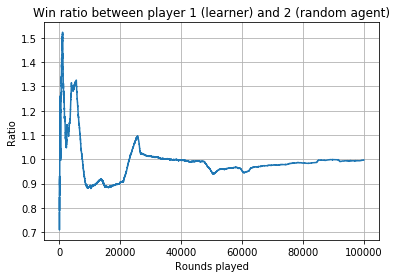

In [393]:
plt.title('Win ratio between player 1 (learner) and 2 (random agent)')
plt.xlabel('Rounds played'); plt.ylabel('Ratio')
plt.plot(learner.x[100:], learner.wins_ratios[100:])
plt.grid()
plt.savefig('100000-selfPlay-v1.png')

In [394]:
output_dict = {}
for k, v in learner.qsa_table.items():
    output_dict[str(k)] = {}
    for k1, v1 in v.items():
        output_dict[str(k)][str(k1)] = str(v1)

In [413]:
# https://stackoverflow.com/questions/7100125/storing-python-dictionaries
with open('100000-selfPlay-qsaTable-v1.json', 'w') as fp:
    json.dump(output_dict, fp)

In [416]:
with open('100000-selfPlay-qsaTable-v1.json', 'r') as fp:
    input_dict = json.load(fp)

In [417]:
# turn off non-greedy actions during game
learner_from_json = Learner(TicTacToeSmall(), num_iters=0, epsilon=0, opponent='random', method='tabular')

In [418]:
def string_tuple_to_tuple(string_tuple):
    a, b = map(int, tuple(string_tuple[1:-1].split(', ')))
    return a, b

In [419]:
for k, v in input_dict.items():
    learner_from_json.qsa_table[int(k)] = {}
    for k1, v1 in v.items():
        learner_from_json.qsa_table[int(k)][string_tuple_to_tuple(k1)] = float(v1)

In [412]:
learner_from_json.interact()

xoo
oox
xxo
Draw.
Would you like to play again? [y or n]n
See you!
